## Sensitivity Analysis

Some experimentation with local and global sensitivity analysis based on the notebook provided by the course and some articles

#### References
- Broeke, G. ten, Voorn, G. van, Ligtenberg, A. (2016). Which Sensitivity Analysis Method Should I Use for My Agent-Based Model?



### OFAT
One-Factor-At-a-Time: Method of local sensitivity analysis, where one input parameter is varied and the others are kept fixed. According to ten Broeke (2016) a pre-test needs to be done to ensure a the model converges to a steady state behaviour. This might prove problematic for our model, since we examine early stage colonies, and in the results from the ODE model, the ant and fungus biomass are still increasing vastly. 

In [1]:
from leafcutter_ants_fungi_mutualism.model import LeafcutterAntsFungiMutualismModel, track_ants, track_leaves, track_ratio_foragers
from mesa.batchrunner import BatchRunner, BatchRunnerMP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
"""
Pre-test to determine whether the model converges to a steady state behaviour
"""
model = LeafcutterAntsFungiMutualismModel(num_ants=50, num_plants=30, width=20, height=50,
                 pheromone_lifespan=30, num_plant_leaves=100,
                 leaf_regrowth_rate=1/2, ant_death_probability=0.01,
                 initial_fungus_energy=50, fungus_decay_rate=1/50)

repetitions = 3
time_steps = 1000

output_variables = {"Ants_Biomass": track_ants,
                    "Fungus_Biomass": lambda m: m.fungus.biomass,
                    "Ants with Leaves": track_leaves,
                    "Fraction forager ants": track_ratio_foragers,
}

variable_parameters = {'num_ants': [20,50]}

# batch = BatchRunner(LeafcutterAntsFungiMutualismModel,
#                     max_steps = time_steps, 
#                     variable_parameters = variable_parameters,
#                     iterations = repetitions,
#                     model_reporters = output_variables,
#                     display_progress = True)

batch = BatchRunnerMP(LeafcutterAntsFungiMutualismModel, #nr_processes = 8,
                    max_steps = time_steps, 
                    variable_parameters = variable_parameters,
                    iterations = repetitions,
                    model_reporters = output_variables,
                    display_progress = True)

batch.run_all()

data = batch.get_model_vars_dataframe()

print(data)

BatchRunner MP will use 8 processors.


6it [01:02, 10.35s/it]

   num_ants  Run  Ants with Leaves  Ants_Biomass  Fraction forager ants  \
2        50    0               165           787               0.240152   
3        20    0               193          1053               0.244065   
0        50    1               171           627               0.197767   
5        20    1               196          1101               0.261580   
1        20    2               172           888               0.243243   
4        50    2               210          1098               0.282332   

   Fungus_Biomass  
2        6.409539  
3        6.119391  
0        6.768214  
5        6.743843  
1        6.153851  
4        6.450364  


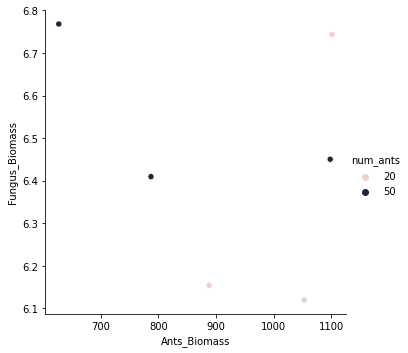

In [9]:
#data_collection = batch.get_collector_model()
sns.relplot(data=data, x='Ants_Biomass', y='Fungus_Biomass', hue='num_ants')

In [12]:
data_collection = batch.get_collector_model()
print(data_collection.keys())

# every key - value pair (nr_ants, repetition_number) contains a single model run
print(data_collection[(20,1)])
# sns.relplot(data=data_collection[(20,1)])
# sns.relplot(data=data_collection[(50,1)])

odict_keys([(50, 1), (20, 2), (50, 0), (20, 0), (50, 2), (20, 1)])
      Fungus Biomass  Ant Biomass  Ants with Leaves  Fraction forager ants
0          50.000000           20                 0               0.500000
1          50.000000           20                 0               0.500000
2         139.760000           21                 0               0.476190
3         128.071200           32                 0               0.562500
4         113.480844           46                 0               0.586957
...              ...          ...               ...                    ...
996         6.914998         1121               187               0.262266
997         6.880423         1119               191               0.260054
998         6.846021         1110               186               0.261261
999         6.811791         1112               188               0.259892
1000        6.777732         1114               194               0.263016

[1001 rows x 4 columns]


In [24]:
""" 
Code based on the sensitivity analysis notebook
"""

# define variables and bounds
# problem is a dictionary, the keys are the variable (parameter) names, 
# the values are a list of the type and bounds
problem = {'num_ants': [int, [1,100]],
           'num_plants': [int, [1,100]], 
           'pheromone_lifespan': [int, [5, 100]],
           'num_plant_leaves': [int, [10, 200]],
           'initial_foragers_ratio': [float, [0.1, 1.0]], 
           'leaf_regrowth_rate': [float, [0.01, 1.0]],
           'ant_death_probability': [float, [0, 0.2]],
           'initial_fungus_energy': [float, [10, 100]],
           'fungus_decay_rate': [float, [0.001, 0.1]], 
           'energy_biomass_cvn': [float, [1, 3]], 
           'fungus_larvae_cvn': [float, [0.5, 1.5]],
           'energy_per_offspring': [float, [1.0, 10]],
           'fungus_feed_threshold': [float, [5.0, 20.0]],
           'max_fitness_queue_size': [int, [1, 100]],
}

# standard parameters:
# num_ants=50, num_plants=30, width=20, height=50,
#                  pheromone_lifespan=30, num_plant_leaves=100,
#                  initial_foragers_ratio=0.5,
#                  leaf_regrowth_rate=1/2, ant_death_probability=0.01,
#                  initial_fungus_energy=50, fungus_decay_rate=0.005,
#                  energy_biomass_cvn=2.0, fungus_larvae_cvn=0.9, energy_per_offspring=1.0,
#                  fungus_biomass_death_threshold=5.0, fungus_feed_threshold=5.0,
#                  max_fitness_queue_size=20)


# define fixed parameters
# fixed_params = {}

# set the repetitions, amount of steps, amount of distinc_samples
repetitions = 5
max_steps = 500
distinct_samples = 5

# set the outputs
model_reporters = {"Ants_Biomass": track_ants,
                "Fungus_Biomass": lambda m: m.fungus.biomass,
                "Fraction forager ants": track_ratio_foragers,
}

data = {}


for var in problem.keys():
    # get the sample for this variable
    samples = np.linspace(*problem[var][1], num=distinct_samples, dtype=problem[var][0])

    
#     print(var, sample, type(sample[2]))
    batch = BatchRunnerMP(LeafcutterAntsFungiMutualismModel, 
                        max_steps=max_steps,
                        iterations=replicates,
                        variable_parameters={var: samples},
                        model_reporters=model_reporters,
                        display_progress=True)
                        # fixed_parameters = ...

    batch.run_all()

    data[var] = batch.get_model_vars_dataframe()




BatchRunner MP will use 8 processors.


25it [01:26,  3.46s/it]

BatchRunner MP will use 8 processors.



25it [00:52,  2.10s/it]

BatchRunner MP will use 8 processors.



25it [01:19,  3.19s/it]

BatchRunner MP will use 8 processors.



25it [01:32,  3.69s/it]

BatchRunner MP will use 8 processors.



25it [01:26,  3.46s/it]

BatchRunner MP will use 8 processors.



25it [01:26,  3.47s/it]

BatchRunner MP will use 8 processors.



25it [01:12,  2.90s/it]

BatchRunner MP will use 8 processors.



25it [01:33,  3.76s/it]

BatchRunner MP will use 8 processors.



25it [00:50,  2.01s/it]

BatchRunner MP will use 8 processors.



25it [01:43,  4.12s/it]

BatchRunner MP will use 8 processors.



25it [01:55,  4.61s/it]

BatchRunner MP will use 8 processors.



25it [00:32,  1.28s/it]

BatchRunner MP will use 8 processors.



25it [01:31,  3.67s/it]

BatchRunner MP will use 8 processors.



25it [01:27,  3.52s/it]


In [29]:
# the following functions are copied directly from the notebook and still need to be adapted
def plot_param_var_conf(ax, df, var, param, i):
    """
    Helper function for plot_all_vars. Plots the individual parameter vs
    variables passed.

    Args:
        ax: the axis to plot to
        df: dataframe that holds the data to be plotted
        var: variables to be taken from the dataframe
        param: which output variable to plot
    """
    x = df.groupby(var).mean().reset_index()[var]
    y = df.groupby(var).mean()[param]

    replicates = df.groupby(var)[param].count()
    err = (1.96 * df.groupby(var)[param].std()) / np.sqrt(replicates)

    ax.plot(x, y, c='k')
    ax.fill_between(x, y - err, y + err)

    ax.set_xlabel(var)
    ax.set_ylabel(param)

def plot_all_vars(df, param):
    """
    Plots the parameters passed vs each of the output variables.

    Args:
        df: dataframe that holds all data
        param: the parameter to be plotted
    """

    f, axs = plt.subplots(len(problem.keys()), figsize=(7, 50))
    
    for i, var in enumerate(problem.keys()):
        plot_param_var_conf(axs[i], data[var], var, param, i)


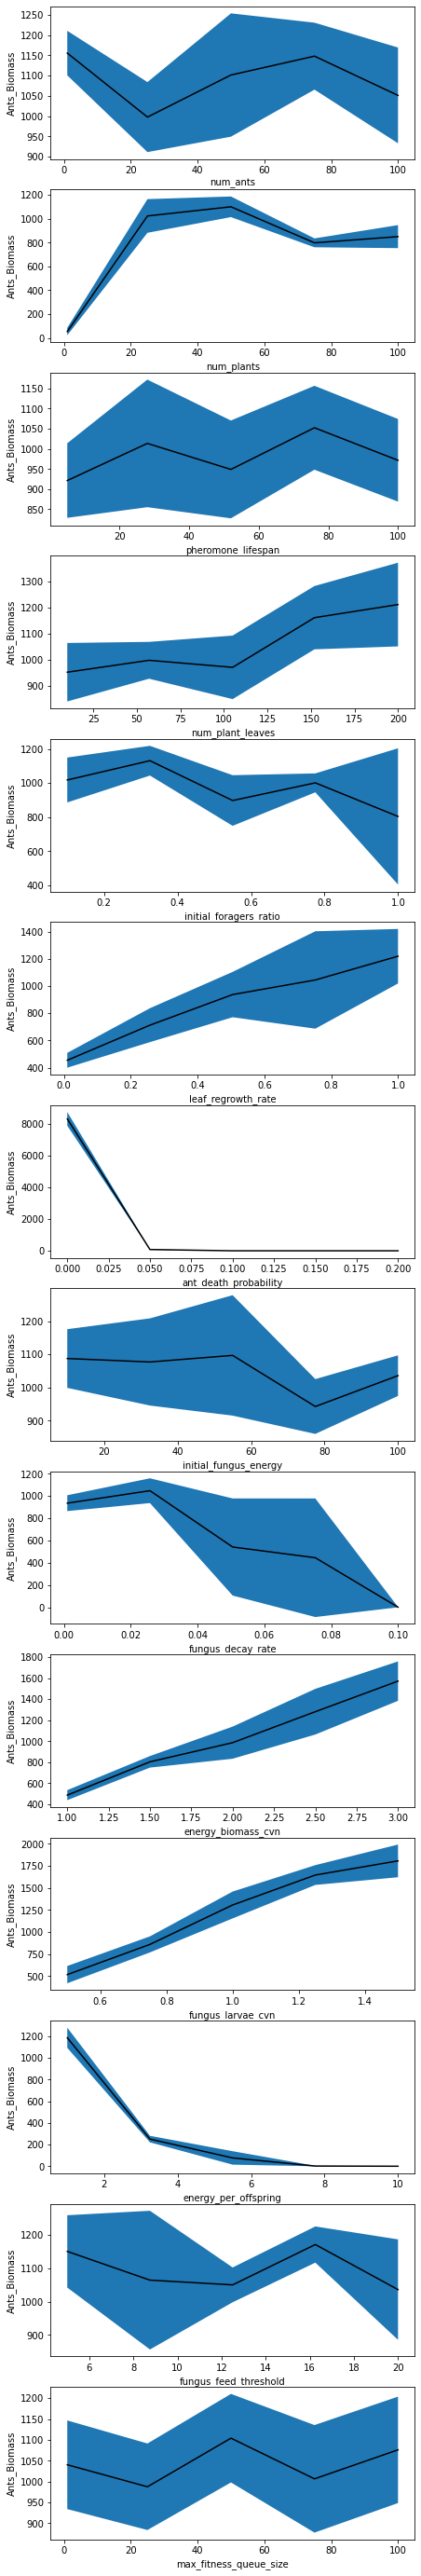

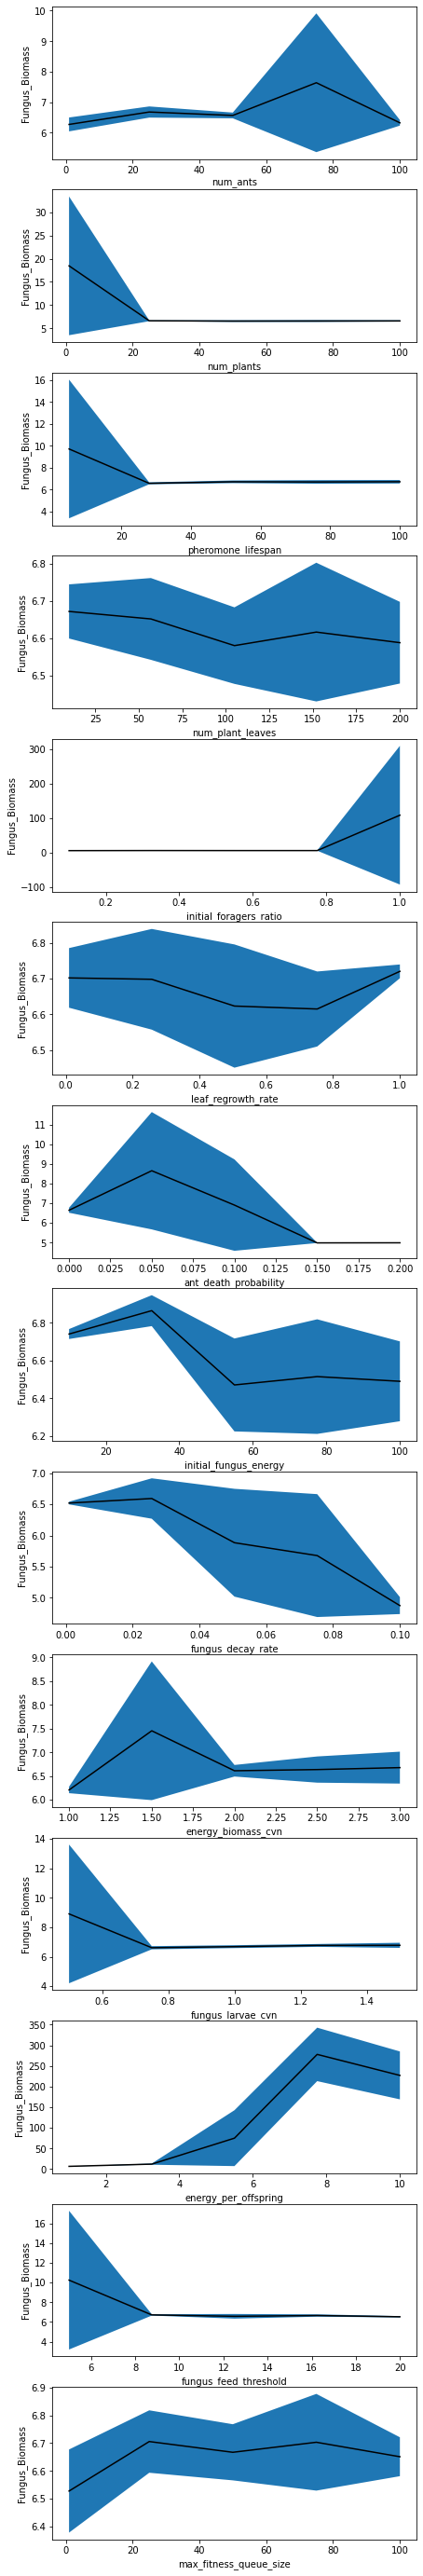

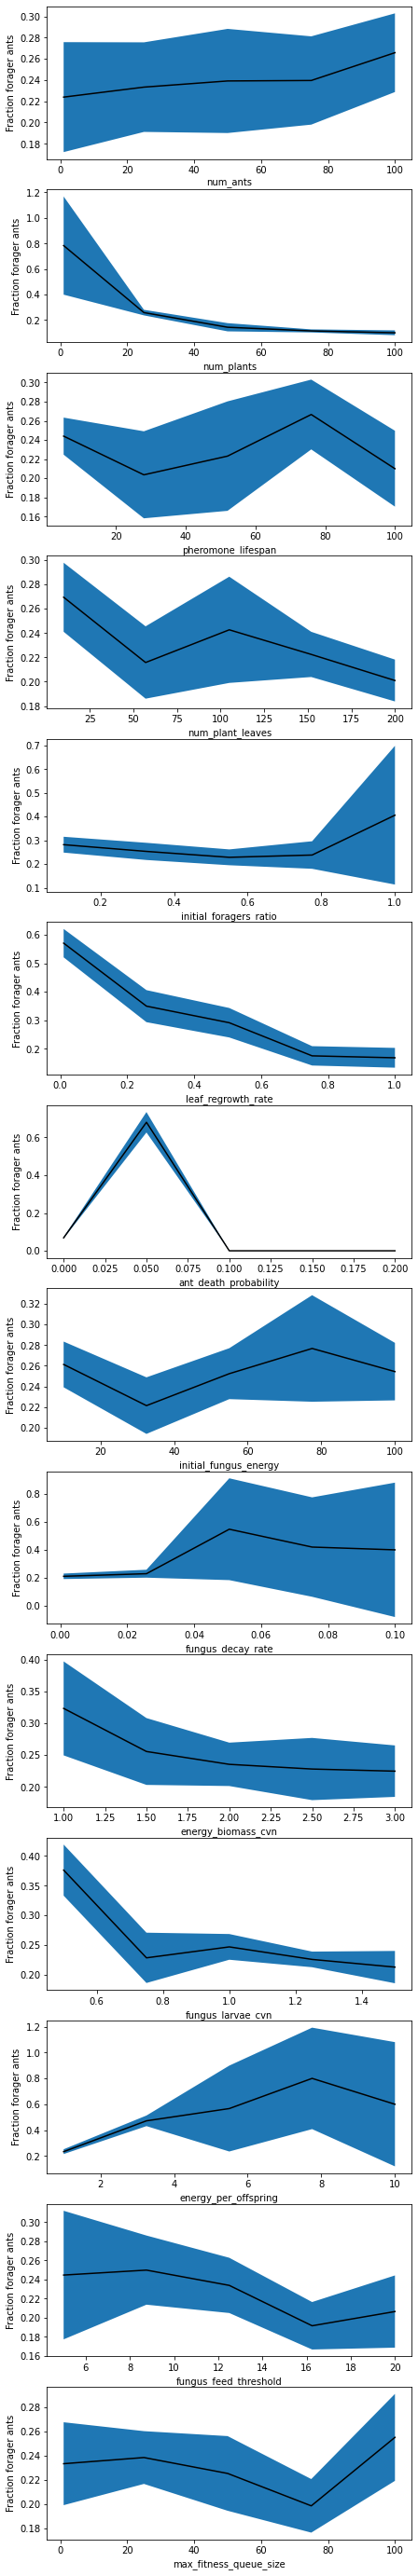

In [30]:
for param in ("Ants_Biomass", "Fungus_Biomass", "Fraction forager ants"):
    plot_all_vars(data, param)
    plt.show()

In [49]:
df = data['num_ants']

print(df[df['num_ants'] == 100])

    num_ants  Run  Ants_Biomass  Fraction forager ants  Fungus_Biomass
18       100    0           921               0.214984        6.497686
24       100    1          1151               0.265856        6.274740
20       100    2          1141               0.266433        6.219360
21       100    3          1156               0.250000        6.309962
23       100    4           887               0.331454        6.313552
